In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


Episode 1/1000: Total Reward = -11443.00, Epsilon = 0.995
Episode 2/1000: Total Reward = -33231.00, Epsilon = 0.990
Episode 3/1000: Total Reward = -4561.00, Epsilon = 0.985
Episode 4/1000: Total Reward = -24778.00, Epsilon = 0.980
Episode 5/1000: Total Reward = -35187.00, Epsilon = 0.975
Episode 6/1000: Total Reward = -2330.00, Epsilon = 0.970
Episode 7/1000: Total Reward = -26084.00, Epsilon = 0.966
Episode 8/1000: Total Reward = -15853.00, Epsilon = 0.961
Episode 9/1000: Total Reward = -10624.00, Epsilon = 0.956
Episode 10/1000: Total Reward = -4181.00, Epsilon = 0.951
Episode 11/1000: Total Reward = -4136.00, Epsilon = 0.946
Episode 12/1000: Total Reward = -23222.00, Epsilon = 0.942
Episode 13/1000: Total Reward = -15579.00, Epsilon = 0.937
Episode 14/1000: Total Reward = -16469.00, Epsilon = 0.932
Episode 15/1000: Total Reward = -6577.00, Epsilon = 0.928
Episode 16/1000: Total Reward = -2398.00, Epsilon = 0.923
Episode 17/1000: Total Reward = -8121.00, Epsilon = 0.918
Episode 18/10

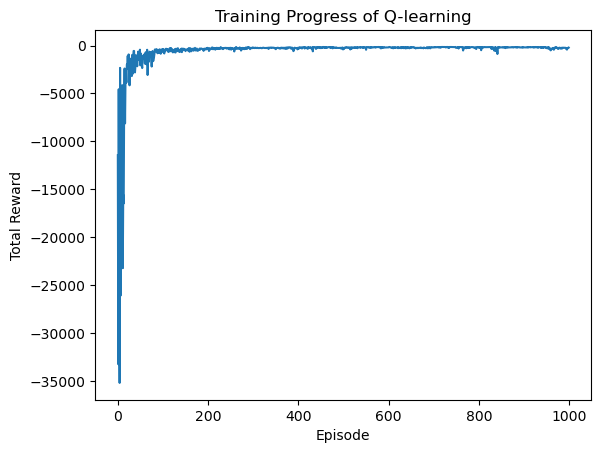

2025-03-13 19:08:15.985 python[8076:228026] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-13 19:08:15.985 python[8076:228026] +[IMKInputSession subclass]: chose IMKInputSession_Modern



Running optimal policy - Episode 1
Episode 1 finished with Total Reward: -234.0

Running optimal policy - Episode 2
Episode 2 finished with Total Reward: -237.0

Running optimal policy - Episode 3


KeyboardInterrupt: 

In [4]:
class UniformDiscretizer:
    def __init__(self, env, num_bins):
        self.env = env
        
        # Get the lower and upper bounds for each dimension in the observation space.
        self.obs_space_low = env.observation_space.low
        self.obs_space_high = env.observation_space.high
        
        # Convert num_bins to a numpy array if it's not already one.
        self.num_bins = np.array(num_bins)
        
        # Compute the width of each bin for each state dimension.
        self.bin_width = (self.obs_space_high - self.obs_space_low) / self.num_bins

    def discretize(self, obs):
        # Calculate bin indices by subtracting the lower bounds and dividing by the bin width.
        bin_indices = ((obs - self.obs_space_low) / self.bin_width).astype(int)
        
        # Ensure indices are within the valid range [0, num_bins-1] for each dimension.
        bin_indices = np.clip(bin_indices, 0, self.num_bins - 1)
        
        # Convert the array of indices to a tuple (useful for indexing a Q-table).
        return tuple(bin_indices)

def q_learning(env, discretizer, episodes=1000, alpha=0.1, gamma=0.99, epsilon=1, epsilon_min =0.05, decay_rate = 0.995):
    num_actions = env.action_space.n
    q_table = {}  # Q-values stored as: {state_tuple: np.array([q(a0), q(a1), ...])}
    episode_rewards = []

    def get_q(state):
        if state not in q_table:
            q_table[state] = np.zeros(num_actions)
        return q_table[state]
    #epilson = epsilon
    for episode in range(episodes):
        obs, _ = env.reset()
        state = discretizer.discretize(obs)
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(get_q(state))
            
            next_obs, reward, done, truncated, _ = env.step(action)
            next_state = discretizer.discretize(next_obs)
            total_reward += reward
            
            # Q-learning update: off-policy update using max_a' Q(s', a')
            best_next = np.max(get_q(next_state))
            q_table[state][action] += alpha * (reward + gamma * best_next - q_table[state][action])
            
            state = next_state
        epsilon = max(epsilon_min, epsilon * decay_rate)
        episode_rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")
    return q_table, episode_rewards

def run_optimal_policy(env, discretizer, q_table, episodes=5, render=True):
    """
    Run the optimal policy derived from the Q-table, rendering each step.
    """
    for episode in range(episodes):
        obs, _ = env.reset()
        state = discretizer.discretize(obs)
        done = False
        total_reward = 0
        print(f"\nRunning optimal policy - Episode {episode+1}")
        while not done:
            # Always choose the best action (greedy policy)
            action_values = q_table.get(state, np.zeros(env.action_space.n))
            action = np.argmax(action_values)
            
            # Render the environment
            if render:
                env.render()
            
            next_obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = discretizer.discretize(next_obs)
        print(f"Episode {episode+1} finished with Total Reward: {total_reward}")
    env.close()


env = gym.make("MountainCar-v0")  # "human" for visualization
num_bins = 20
discretizer = UniformDiscretizer(env, num_bins)

# Train the Q-learning agent
q_table, rewards = q_learning(env, discretizer, episodes=1000)

# Optionally, plot the rewards over episodes
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of Q-learning")
plt.show()

env2 = gym.make("MountainCar-v0", render_mode = "human")

# After training, run the optimal policy with rendering to see how it performs.
run_optimal_policy(env2, discretizer, q_table, episodes=5, render=True)